# Julia in Computational Biology -- Michaelis-Menten reactions

This notebook is heavily inspired by the SIAM review paper by Des Higham "Modeling and Simulating
Chemical Reactions"(http://epubs.siam.org/doi/pdf/10.1137/060666457). Excellent documentation for DifferentialEquations.jl can be found here http://docs.juliadiffeq.org/latest/

Two 20th century scientists, Leonor Michaelis and Maud Leonora Menten, proposed the model known as Michaelis-Menten Kinetics to account for enzymatic dynamics. The year 2013 marked the centenary of the paper of Leonor Michaelis and Maud Menten (http://pubs.acs.org/doi/abs/10.1021/bi201284u). 

This publication has had an enormous influence on the progress of biochemistry, and has been more often cited in the 21st century than in the 20th. Can also think of it as a simple model of mRNA translation. 

1. $[E] + [S] \xrightarrow[ ]{k_1}[ES]$ 
2. $[ES] \xrightarrow[ ] {k_2} [E] + [P]$ 
3. $[ES] \xrightarrow[ ]{k_3} [E] + [S]$

Let's begin by assuming chemical reactants are well-mixed, spatially homogeneous. The Gillespie algorithm (stochastic simulation algorithm) generates a statistically correct trajectory (possible solution) of a chemical master equation. First, let's call on the DifferentialEquations.jl package and define initial conditions and some parameters.

In [1]:
using DifferentialEquations, Plots
const k_1 = 1e-3
const k_2 = 1e-1
const k_3 = 1e-2
const starty = [100.0; 300.0; 0.0; 0.0;];

Next we define the Michaelis-menten Gillespie problem...

In [2]:
r1 = Reaction(k_1,[1,2],[(1,-1),(2,-1),(3,1)])
r2 = Reaction(k_2,[3],[(1,1),(3,-1),(4,1)])
r3 = Reaction(k_3,[3],[(1,1),(2,1),(3,-1)])
prob = DiscreteProblem([Int(starty[1]),Int(starty[2]),0,0],(0.0,50.0))
jump_prob = GillespieProblem(prob,Direct(),r1,r2,r3);

  4.180365 seconds (6.30 M allocations: 240.258 MB, 3.59% gc time)
  0.000451 seconds (3.04 k allocations: 250.875 KB)



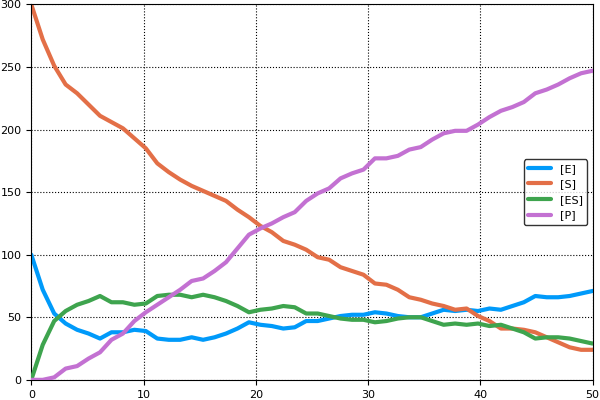

In [3]:
@time out = solve(jump_prob,Discrete(),saveat=linspace(0.0,50.0,50));
@time out = solve(jump_prob,Discrete(),saveat=linspace(0.0,50.0,50));
ssa_data=zeros(length(out),4);for i = 1:length(out);for j = 1:4; ssa_data[i,j] = out.u[i][j]; end; end; 
plot(out.t,ssa_data,label=["[E]" "[S]" "[ES]" "[P]"],linewidth=3.0)

As with the chemical master equation, the SSA converges, in the limit of large numbers of reactants, to the same solution as the law of mass action. We can check this...

Applying the law of mass action, which states that the rate of a reaction is proportional to the product of the concentrations of the reactants (i.e. [E][S]), gives a system of four non-linear ordinary differential equations that define the rate of change of reactants with time

$\begin{align}
\frac{d[E]}{dt} &= - k_1 [E][S] + k_3 [ES] + k_{2} [ES] \\
\frac{d[S]}{dt} &= - k_1 [E][S] + k_3 [ES] \\
\frac{d[ES]}{dt} &=  k_1 [E][S] - k_3 [ES] - k_{2} [ES] \\
\frac{d[P]}{dt} &=  k_{2} [ES].
\end{align}$

We can simulate such a system by encoding this function in the form ${\bf y}' = {\bf f}(t, {\bf y})$. 

In [4]:
function f(t,u,du)
    # Our system of differential equations
    du[1] = -k_1*u[1]*u[2] + k_3*u[3] + k_2*u[3] #[E] 
    du[2] = -k_1*u[1]*u[2] + k_3*u[3]  #[S] 
    du[3] = k_1*u[1]*u[2] - k_3*u[3] - k_2*u[3] #[ES]
    du[4] = k_2*u[3] # [P] 
end

f (generic function with 1 method)

In [5]:
prob2 = ODEProblem(f,starty,(0.0,50.0));

  2.893681 seconds (3.00 M allocations: 117.335 MB, 1.34% gc time)
  0.000335 seconds (468 allocations: 34.776 KB)



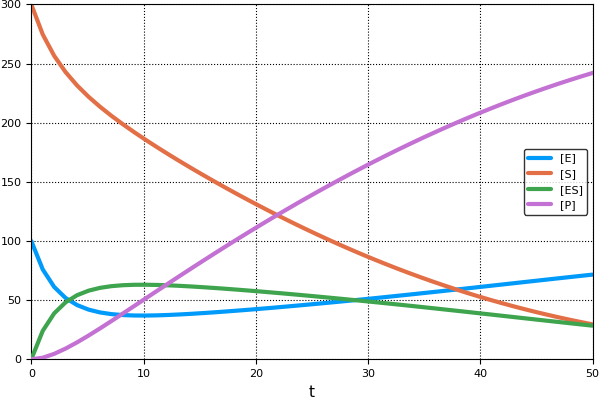

In [6]:
@time out1 = solve(prob2,saveat=linspace(0.0,50.0,50));
@time out1 = solve(prob2,saveat=linspace(0.0,50.0,50));
plot(out1,label=["[E]" "[S]" "[ES]" "[P]"])

In [7]:
ssprob = SteadyStateProblem(f,starty)
@time ss_sol = solve(ssprob,SSRootfind())
println(ss_sol.u)

  2.432136 seconds (2.58 M allocations: 101.364 MB, 1.53% gc time)
[3.53591e-11,269.63,0.0,0.0]


Can check accuracy of solution by taking limit as $t$ $\to$ $\infty$

  0.261794 seconds (301.17 k allocations: 13.099 MB, 3.25% gc time)



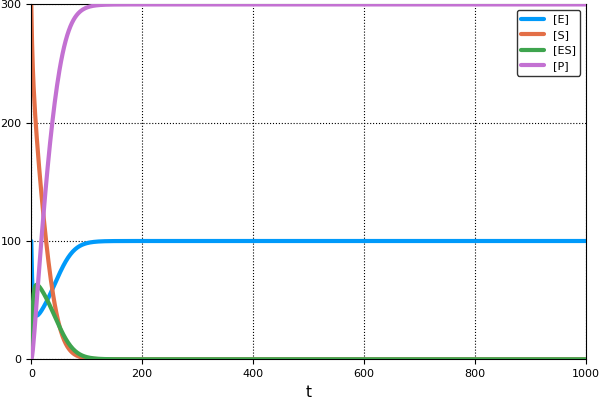

In [8]:
prob2_long = ODEProblem(f,starty,(0.0,1000.0));
@time out1_long = solve(prob2_long);
plot(out1_long,label=["[E]" "[S]" "[ES]" "[P]"])

As an alternative to using the Gillespie algorithm, we can add noise to the ODE system to create a system of stochastic differential equations (chemical langevin equations)

In [9]:
σ = (t,u,du) -> begin
    du[1] = sqrt(abs(k_1*u[1]*u[2] + k_3*u[3] + k_2*u[3]))
    du[2] = sqrt(abs(-k_1*u[1]*u[2] + k_3*u[3]))
    du[3] = sqrt(abs(k_1*u[1]*u[2] - k_3*u[3] - k_2*u[3]))
    du[4] = sqrt(abs(k_2*u[3]))
end

(::#1) (generic function with 1 method)

In [10]:
prob3 = SDEProblem(f,σ,starty,(0.0,50.0));

In [11]:
@time out2 = solve(prob3,SRIW1(),saveat=linspace(0.0,50.0,50));
@time out2 = solve(prob3,SRIW1(),saveat=linspace(0.0,50.0,50));

  3.246023 seconds (4.06 M allocations: 177.798 MB, 1.93% gc time)
  0.001644 seconds (6.18 k allocations: 447.922 KB)



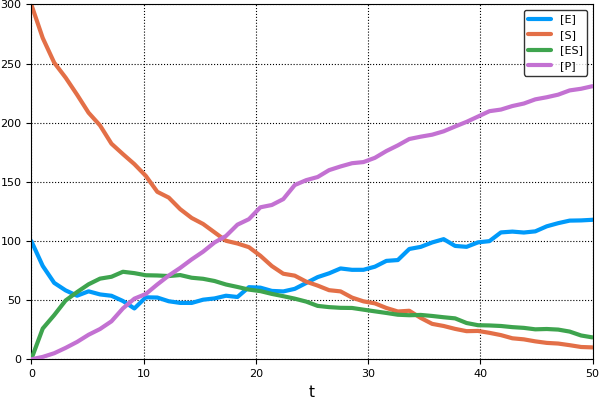

In [12]:
plot(out2,label=["[E]" "[S]" "[ES]" "[P]"])

Using the plots package it is then easy to compare the output from these different simulation methods.


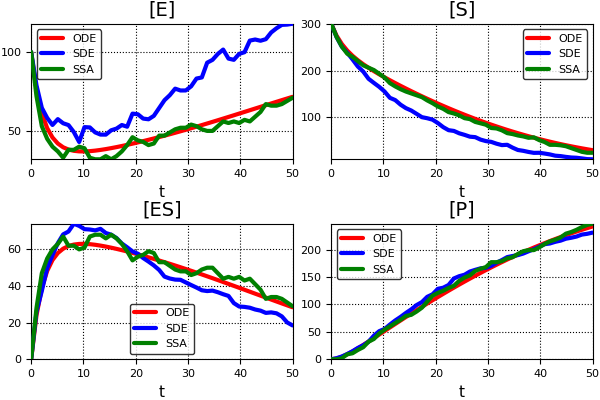

In [13]:
plot(out1,colour = "red",label="ODE",layout = 4)
plot!(out2,colour = "blue",label="SDE",layout = 4)
plot!(out.t,ssa_data,colour = "green",label="SSA",layout = 4,title=["[E]" "[S]" "[ES]" "[P]"],linewidth=3.0)

It is also possible to introduce a delay into the formation of enzyme-substrate complexes (for example). To do this we redefine the system as...

In [14]:
function fdelay(t,u,h,du)
    # Our system of delay differential equations
    du[1] = -k_1*u[1]*u[2] + k_3*u[3] + k_2*h(t-tau)[3]
    du[2] = -k_1*u[1]*u[2] + k_3*u[3]
    du[3] = k_1*u[1]*u[2] - k_3*u[3] - k_2*h(t-tau)[3]
    du[4] = k_2*h(t-tau)[3]
end;

In [15]:
tau = 10.0
lags = [tau]
h(t) = zeros(4).*starty
prob = ConstantLagDDEProblem(fdelay,h,starty,lags,(0.0,50.0))
alg = MethodOfSteps(Tsit5())
@time out3 = solve(prob,alg);
@time out3 = solve(prob,alg);

  3.172170 seconds (3.04 M allocations: 120.916 MB, 4.72% gc time)
  0.001025 seconds (7.21 k allocations: 259.245 KB)



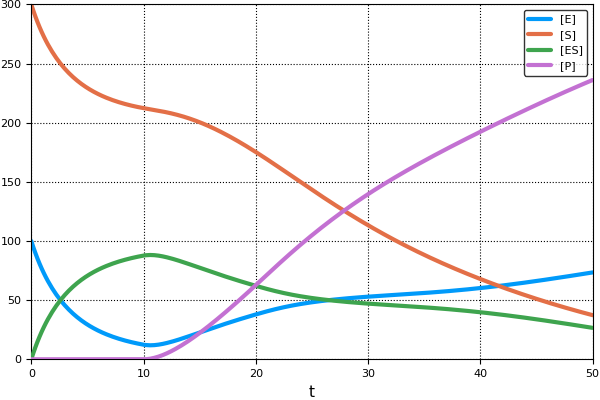

In [16]:
plot(out3,label=["[E]" "[S]" "[ES]" "[P]"])

We can also extend the system to account for space explicitly...i.e., relax the well-mixed assumption. Consider a scenario where the enzyme and substrate are poured into opposite corners of a square container.

In [17]:
#Define a parabolic PDE problem
const D=[0.5e-2 0.5e-2 1e-3 1e-3]
T = (0.0,5.0)
Δx = (1)//2^(4)
Δt = 1//2^(10)
mesh = parabolic_squaremesh([0 1 0 1],Δx,Δt,T,:neumann)

f1(t,x,u)  = -k_1.*u[:,1].*u[:,2] + k_3.*u[:,3] + k_2.*u[:,3]
f2(t,x,u)  = -k_1.*u[:,1].*u[:,2] + k_3.*u[:,3]
f3(t,x,u)  = k_1.*u[:,1].*u[:,2] - k_3.*u[:,3] - k_2.*u[:,3]
f4(t,x,u)  = k_2.*u[:,3]
g(t,x,u) = [f1(t,x,u) f2(t,x,u) f3(t,x,u) f4(t,x,u)]
u0_func(x) = [5000.*((abs(x[:,1]-.25) .< 1e-6)&(abs(x[:,2]-.25) .< 1e-6)) 5000.*((abs(x[:,1]-.75) .< 1e-6) & (abs(x[:,2]-.75) .< 1e-6)) zeros(size(x,1)) zeros(size(x,1))]
u0 = u0_func(mesh.node)

prob = HeatProblem(u0,g,mesh,D=D)
@time sol = solve(prob,FEMDiffEqHeatEuler(),save_everystep=true);

 22.863215 seconds (168.76 M allocations: 16.461 GB, 10.10% gc time)


In [18]:
animate(sol,"spatial_mm.gif",zlim=[(0,maximum(sol.u[end],1)[1]) (0,maximum(sol.u[end],1)[2]) (0,maximum(sol.u[end],1)[3]) (0,maximum(sol.u[end],1)[4])],cbar=false,title=["[E]" "[S]" "[ES]" "[P]"],size=(1000,1000))

INFO: Saved animation to /Users/Msturrock/Google Drive/spatial_mm.gif


Plots.AnimatedGif("/Users/Msturrock/Google Drive/spatial_mm.gif")

It is also possible to add noise to spatial models..

In [19]:
σ1 = (t,x,u) -> sqrt(abs(k_1.*u[:,1].*u[:,2] + k_3.*u[:,3] + k_2.*u[:,3]))
σ2 = (t,x,u) -> sqrt(abs(-k_1.*u[:,1].*u[:,2] + k_3.*u[:,3]))
σ3 = (t,x,u) -> sqrt(abs(k_1.*u[:,1].*u[:,2] - k_3.*u[:,3] - k_2.*u[:,3]))
σ4 = (t,x,u) -> sqrt(abs(k_2.*u[:,3]))
sigma(t,x,u) = [σ1(t,x,u) σ2(t,x,u) σ3(t,x,u) σ4(t,x,u)]

prob2 = HeatProblem(u0,g,mesh,D=D,σ=sigma)
@time sol2 = solve(prob2,FEMDiffEqHeatEuler(),save_everystep=true);

 44.906378 seconds (335.33 M allocations: 27.226 GB, 10.94% gc time)


In [20]:
animate(sol2,"spatial_stochastic_mm.gif",zlim=[(0,maximum(sol2.u[end],1)[1]) (0,maximum(sol2.u[end],1)[2]) (0,maximum(sol2.u[end],1)[3]) (0,maximum(sol2.u[end],1)[4])],cbar=false,title=["[E]" "[S]" "[ES]" "[P]"],size=(1000,1000))

INFO: Saved animation to /Users/Msturrock/Google Drive/spatial_stochastic_mm.gif


Plots.AnimatedGif("/Users/Msturrock/Google Drive/spatial_stochastic_mm.gif")

Can also fit model to data, let's say we have some time series experimental data for the product molecule. Let's pretend the SSA data from before is real experimental data. Due to speed of Julia and DifferentialEquations.jl we can take naive approach to fitting models...

INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto



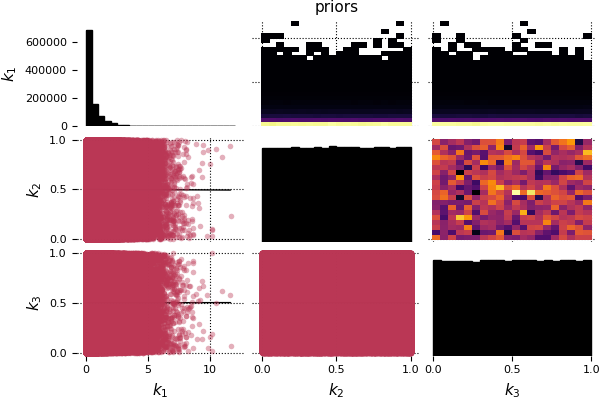

In [21]:
using Distributions
k_1_prior = rand(Gamma(0.5, 1.0),1000000)
k_2_prior = rand(Uniform(0.0, 1.0),1000000)
k_3_prior = rand(Uniform(0.0, 1.0),1000000)

using StatPlots,LaTeXStrings
corrplot(hcat(k_1_prior,k_2_prior,k_3_prior),label=[L"$k_1$", L"$k_2$", L"$k_3$"],title="priors")

Can change priors based on available experimental evidence...

In [22]:
data = ssa_data[:,4]
using Distances 

number_samples = 500

k_1_posterior = zeros(Float64,number_samples)
k_2_posterior = zeros(Float64,number_samples)
k_3_posterior = zeros(Float64,number_samples)
error_posterior = zeros(Float64,number_samples)

function ode_model(k_1,k_2,k_3,starty,ts)
    function f_model(t,u,du)
        du[1] = -k_1*u[1]*u[2] + k_3*u[3] + k_2*u[3]
        du[2] = -k_1*u[1]*u[2] + k_3*u[3]
        du[3] = k_1*u[1]*u[2] - k_3*u[3] - k_2*u[3]
        du[4] = k_2*u[3]
        [u[1]; u[2]; u[3]; u[4]]
    end;
    prob = ODEProblem(f_model,starty,(0.0,maximum(ts)));
    out = solve(prob,saveat=ts)
    model_data=zeros(length(ts),4);for i = 1:length(ts);for j =1:4 model_data[i,j] = out.u[i][j]; end; end;
    return model_data
end
distance = Float64[]
error_estimate = 50.0
i = 0
i2= 0

@time while i < number_samples
   i2 = i2 + 1
   
   simulated_data = ode_model(k_1_prior[i2],k_2_prior[i2],k_3_prior[i2],starty,linspace(0.0,50.0,50))
   distance = evaluate(Euclidean(), data, simulated_data[:,4])
   
    if distance <= error_estimate
        i = i + 1
        k_1_posterior[i] = k_1_prior[i2]
        k_2_posterior[i] = k_2_prior[i2]
        k_3_posterior[i] = k_3_prior[i2]
        error_posterior[i] = distance
    end
end
min_error = minimum(error_posterior)
println("number of simulations performed = $i2 and smallest error found = $min_error")

228.175617 seconds (4.93 G allocations: 163.274 GB, 14.80% gc time)
number of simulations performed = 202915 and smallest error found = 26.952875960540556


This sort of thing is ideal for Julia's parallel stuff (though maybe not on my macbook).


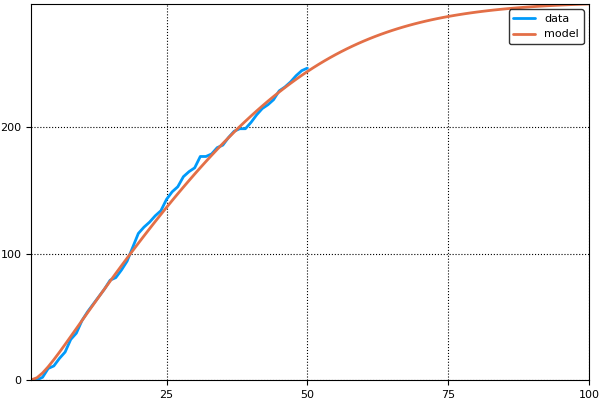

In [23]:
ind=find(error_posterior .== minimum(error_posterior));
simulated_data = ode_model(k_1_posterior[ind[1]],k_2_posterior[ind[1]],k_3_posterior[ind[1]],starty,linspace(0.0,100.0,100))
plot([data,simulated_data[:,4]],linewidth=2.0,label=["data" "model"])

Can make simple predictions about what will happen next. Or can use different initial conditions in fitted model and ask experimentalist to do same. 

INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto
INFO: binning = auto



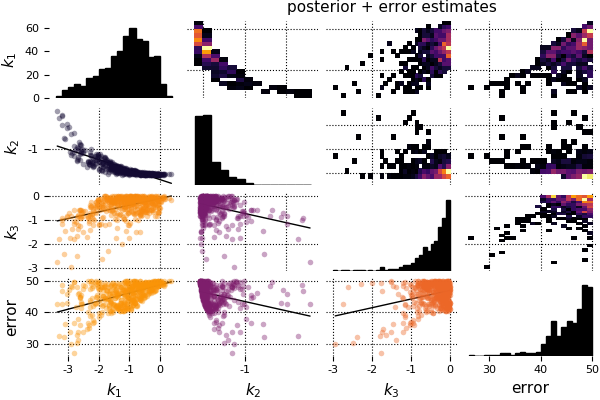

In [24]:
params = hcat(k_1_posterior,k_2_posterior,k_3_posterior,10.^error_posterior);
using StatPlots,LaTeXStrings
corrplot(log10(params),label=[L"$k_1$", L"$k_2$", L"$k_3$","error"],title="posterior + error estimates")

R seems to have better corrplots at this stage. Can you Rcall etc. here instead. 

In [25]:
k_1 = 1e-3
k_2 = 1e-1
k_3 = 1e-2
println([k_1;k_2;k_3])

[0.001,0.1,0.01]



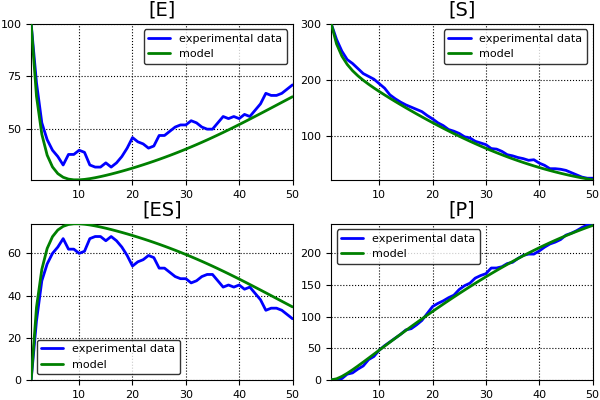

In [26]:
plot(ssa_data,colour = "blue",label="experimental data",layout = 4,linewidth=2.0)
plot!(simulated_data[1:50,:],colour = "green",label="model",layout = 4,title=["[E]" "[S]" "[ES]" "[P]"],linewidth=2.0)

Knowledge of initial conditions and product over time is enough to infer other reactants? Probably need to decrease error guess in ABC algorithm^^ - checkout adaptive ABC-SMC algorithms which remove need for guessing ABC parameters (https://arxiv.org/abs/1111.1308)

Some mathematical considerations that may help the steady state anomaly above..let's revisit original system of equations.

$\begin{align}
\frac{d[E]}{dt} &= - k_1 [E][S] + k_3 [ES] + k_{2} [ES] \\
\frac{d[S]}{dt} &= - k_1 [E][S] + k_3 [ES] \\
\frac{d[ES]}{dt} &=  k_1 [E][S] - k_3 [ES] - k_{2} [ES] \\
\frac{d[P]}{dt} &=  k_{2} [ES].
\end{align}$

Last equation only depends on ES. Hence, we can write its solution as

$\begin{equation}
[P](T) = [P](0) + \int_0^{T} k_2[ES](t) dt
\end{equation}$

Also, as enzyme molecules can be free or locked up in a complex with substrate (and
are neither created nor destroyed) one has that

$\begin{align}
[E](0) + [ES](0) =& [E](t) + [ES](t)\\
[E](t) =& [E](0) + [ES](0) - [ES](t)  
\end{align}$

using this we obtain

$\begin{align}
\frac{d[S]}{dt} &= - k_1 [E][S] + k_3 [ES] \\
                &= - k_1 \big([E](0) + [ES](0) - [ES]\big)[S] + k_3[ES] \\ 
                &= - k_1 \big([E](0)+ [ES](0)\big)[S] + \big(k_3+ k_1[S]\big)[ES] 
\end{align}$

and

$\begin{align}
\frac{d[ES]}{dt} &=  k_1 [E][S] - k_3 [ES] - k_{2} [ES] \\
                &=   k_1 \big([E](0) + [ES](0) - [ES]\big)[S] - k_3 [ES] - k_{2} [ES] \\ 
                &=   k_1 \big([E](0)+ [ES](0)\big)[S] - \big(k_3 + k_2 + k_1[S]\big)[ES] 
\end{align}$

Hence, we have reduced the original 4 ODEs to the following differential algebraic system

$\begin{align}
\frac{d[S]}{dt}&= - k_1 \big([E](0)+ [ES](0)\big)[S] + \big(k_3+ k_1[S]\big)[ES] \\
\frac{d[ES]}{dt} &=   k_1 \big([E](0)+ [ES](0)\big)[S] - \big(k_3 + k_2 + k_1[S]\big)[ES] \\
[E](t) &= [E](0) + [ES](0) - [ES](t) 
\end{align}$

which can be coupled with the equation for the product to get the full solution...

In [27]:
e_0 = 100.0;
es_0 = 0.0;
s_0 = 300.0;
u₀ = [s_0,es_0,e_0]
du₀ = [-k_1*(e_0+es_0)*s_0+(k_3+k_1*s_0)*es_0,k_1*(e_0+es_0)*s_0-(k_3+k_2+k_1*s_0)*es_0,0.0]

3-element Array{Float64,1}:
 -30.0
  30.0
   0.0

In [28]:
f_reduced = function(t,u,du,out)
    out[1] = -k_1*(e_0+es_0)*u[1] + (k_3+k_1*u[1])*u[2] - du[1]
    out[2] = +k_1*(e_0+es_0)*u[1] -(k_3+k_2+k_1*u[1])*u[2] - du[2]
    out[3] = e_0 + es_0 - u[2] - u[3]
end

(::#12) (generic function with 1 method)

  0.554215 seconds (517.23 k allocations: 18.148 MB, 4.33% gc time)



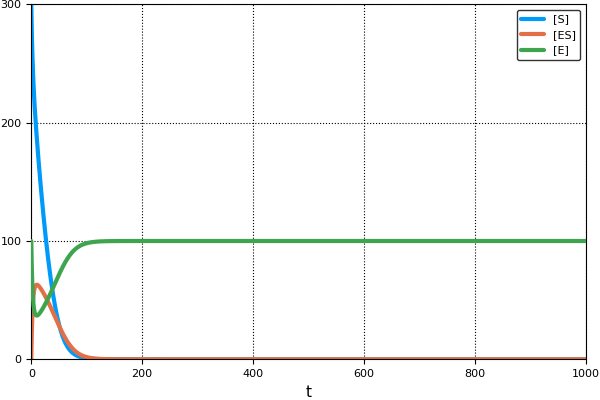

In [32]:
prob_reduced = DAEProblem(f_reduced,u₀,du₀,(0.0,1000.0),differential_vars=[1,1,0])
@time out_reduced = solve(prob_reduced,IDA(),saveat=linspace(0.0,1000.0,1000.0));
plot(out_reduced,label=["[S]" "[ES]" "[E]"])

Hence, we can work out the true steady state for [P] from the remaining equation..

In [34]:
P = 0 + k_2*sum(out_reduced[2,:])

299.43030366098077